In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from keras import Model
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN, GRU

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
MIN_EVENT_TIME = 5
MAX_EVENT_TIME = 20
MIN_EVENT_POWER = 0.05
MAX_EVENT_POWER = 0.5

BASINS = [
    (0.02, 20),
    (0.02, 30),
    (0.01, 35),
    (0.03, 41),
    (0.02, 45),
    (0.01, 54),
    (0.02, 65),
    (0.01, 75),
]

def gen_precip(num_samples, num_events):  
    
    result = np.zeros(num_samples)
    
    for event_start in random.sample(range(num_samples - MAX_EVENT_TIME), num_events):
        event = np.zeros((num_samples,))
        event_time = random.randint(MIN_EVENT_TIME, MAX_EVENT_TIME)
        event_power = random.random() * (MAX_EVENT_POWER - MIN_EVENT_POWER) + MIN_EVENT_POWER
        event[event_start: event_start + event_time] = (np.cos(np.linspace(-np.pi, np.pi, num=event_time)) * 0.5 + 0.5) * event_power
        result += event
    
    return result

def gen_discharge(basins, precip, runoff):            
    all_precip = np.zeros(precip.shape)
    
    for basin in basins:
        lagged = np.roll(precip * basin[0], basin[1])
        lagged[:basin[1]] = 0
        all_precip += lagged
        
    discharge = np.zeros(precip.shape)
        
    for i in range(1, len(discharge)):
        discharge[i] = discharge[i - 1]  * (1 - runoff) + all_precip[i]
        
    return discharge, precip

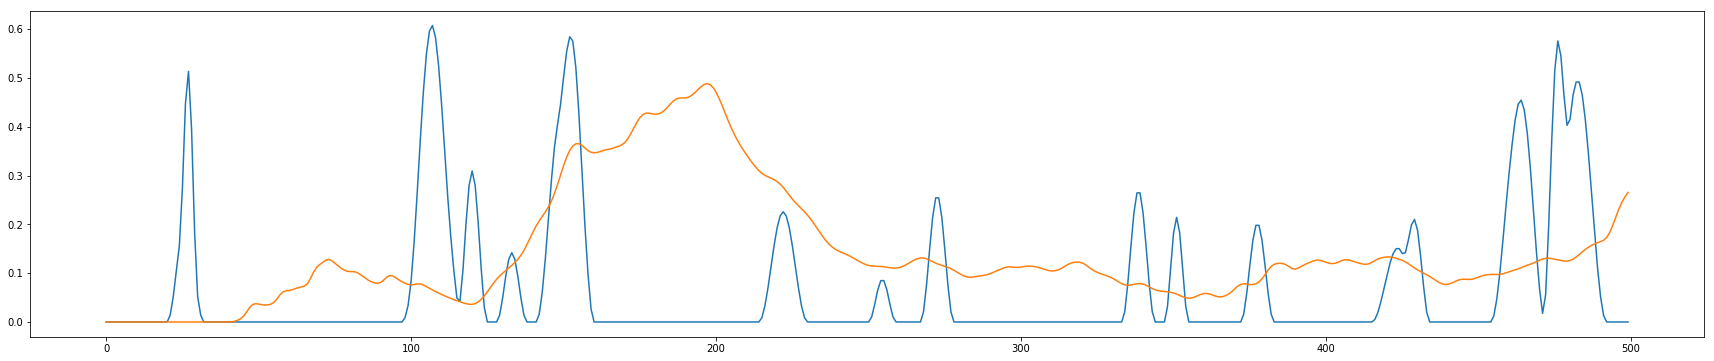

In [3]:
precip = gen_precip(500, 20)
discharge, _ = gen_discharge(BASINS, precip, 0.05)

plt.figure(figsize=(30,6))
plt.plot(precip)
plt.plot(discharge)
plt.show()

In [ ]:
import random

NUM_SAMPLES = 2000
SEQ_LEN = 500

raw_train_Y, raw_train_X = zip(*[gen_discharge(BASINS, gen_precip(SEQ_LEN, 10), 0.01) for i in range(NUM_SAMPLES)])

In [ ]:
inputs = Input(shape=(SEQ_LEN,))
x = Dense(200, activation='tanh')(inputs)
x = Dense(200, activation='tanh')(x)
x = Dense(200, activation='tanh')(x)
outputs = Dense(SEQ_LEN, activation='linear')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

train_X = np.vstack(raw_train_X)
train_Y = np.vstack(raw_train_Y)

In [ ]:
inputs = Input(shape=(None, 1))
x = SimpleRNN(128, return_sequences=True)(inputs)
x = SimpleRNN(64, return_sequences=True)(x)
outputs = SimpleRNN(1, return_sequences=True, activation='linear')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

train_X = np.vstack(raw_train_X).reshape((NUM_SAMPLES, SEQ_LEN, 1))
train_Y = np.vstack(raw_train_Y).reshape((NUM_SAMPLES, SEQ_LEN, 1))

In [ ]:
inputs = Input(shape=(None, 1))
x = LSTM(128, return_sequences=True, recurrent_activation='sigmoid')(inputs)
outputs = Dense(1, activation='linear')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

train_X = np.vstack(raw_train_X).reshape((NUM_SAMPLES, SEQ_LEN, 1))
train_Y = np.vstack(raw_train_Y).reshape((NUM_SAMPLES, SEQ_LEN, 1))

In [ ]:
progress = model.fit(train_X, train_Y, validation_split=0.1, epochs=50)

In [ ]:
TEST_SEQ_LEN = 2000
test_output, test_input = gen_discharge(BASINS, gen_precip(TEST_SEQ_LEN, 40), 0.01)

In [ ]:
prediction = model.predict(test_input.reshape((1, TEST_SEQ_LEN, 1)))[0]

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

In [ ]:
p1 = model.predict(test_input[:SEQ_LEN].reshape((1, SEQ_LEN)))[0]
p2 = model.predict(test_input[SEQ_LEN - 200: 2 * SEQ_LEN - 200].reshape((1, SEQ_LEN)))[0]

plt.figure(figsize=(20,6))
plt.plot(test_input)
plt.plot(range(SEQ_LEN - 200,  2 * SEQ_LEN - 200), p2, 'lime')
plt.plot(range(SEQ_LEN), p1, 'green')
plt.plot(test_output, 'r--')
plt.show()